# Predicting Wine Quality

Regression is the task of fitting a model to data. If things go well, the model might provide useful predictions in response to new data. This notebook shows how linear programming and least absolute deviation (LAD) regression can be used to create a linear model for predicting wine quality based on physical and chemical properties. The example uses a well known data set from the machine learning community.

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## Downloading the data set

Physical, chemical, and sensory quality properties were collected for a large number of red and white wines produced in the Portugal then donated to the UCI machine learning repository (Cortez, Paulo, Cerdeira, A., Almeida, F., Matos, T. & Reis, J.. (2009). Wine Quality. UCI Machine Learning Repository.) The following cell reads the data for red wines directly from the UCI machine learning repository.

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

wines = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
display(wines)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## A preliminary look at the data

The data consists of 1,599 measurements of eleven physical and chemical characteristics plus an integer measure of sensory quality recorded on a scale from 3 to 8. Histograms provides insight into the values and variability of the data set.

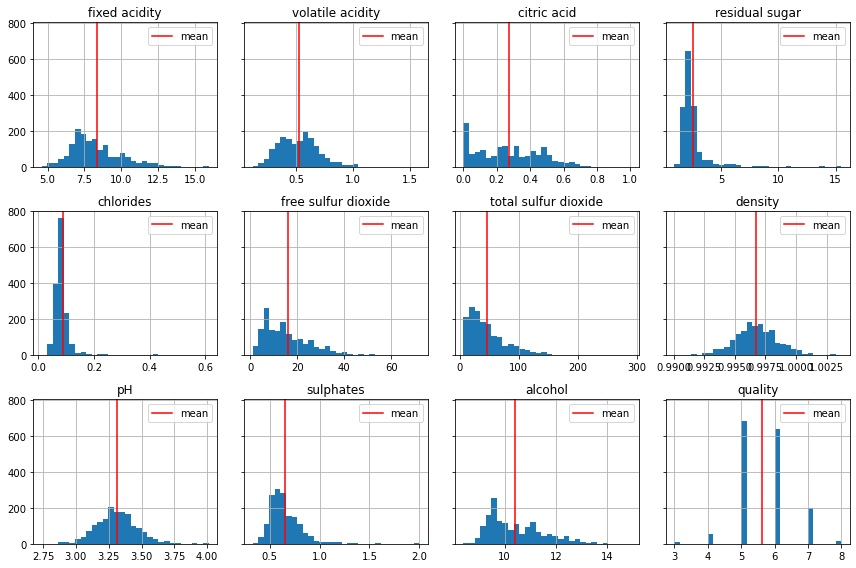

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True)

for ax, column in zip(axes.flatten(), wines.columns):
    wines[column].hist(ax=ax, bins=30)
    ax.axvline(red_wines[column].mean(), color='r', label="mean")
    ax.set_title(column)
    ax.legend()
    
plt.tight_layout()

## Which features influence reported wine quality?

The art of regression is to identify the features that have explanatory value for a response of interest. This is where a person with deep knowledge of an application area, in this case an experienced onenologist will have a head start compared to the naive data scientist. In the absence of the experience, we proceed by examining the correlation among the variables in the data set.

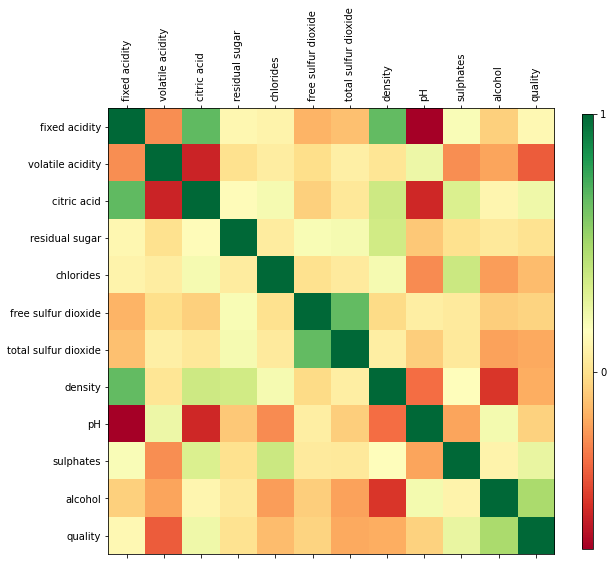

In [74]:
def plot_corr(df, ax):
    corr = df.corr()
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_corr(wines, ax)

The correlation matrix contains rich structure. For example, there is strong correlation among the fixed acidity, volatile acidity, citric acid, and pH. Alcohol and density form another pair of correlated variables as might be expected from chemical considerations. 

The Python `scipy.cluster.hierarchy` provides tools for to reorder the variables in a correlation matrix in related clusters.

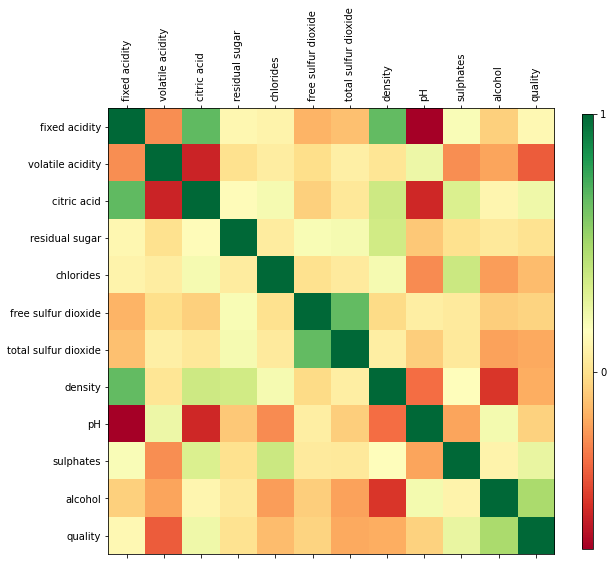

In [91]:
import scipy
import scipy.cluster.hierarchy as sch

df = wines

X = df.corr().values
d = sch.distance.pdist(X) 
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
plot_corr(df, ax)

<AxesSubplot:>

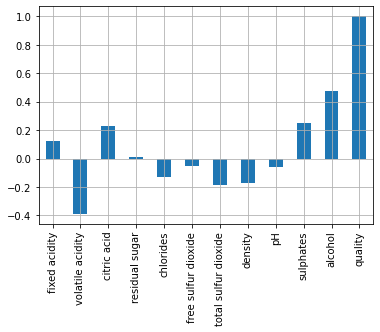

In [98]:
wines.corr()["quality"].plot(kind="bar", grid=True)

In [99]:
wines[["volatile acidity", "density", "alcohol", "quality"]].corr()

,volatile acidity,density,alcohol,quality
volatile acidity,1.000000,0.022026,-0.202288,-0.390558
density,0.022026,1.000000,-0.496180,-0.174919
alcohol,-0.202288,-0.496180,1.000000,0.476166
quality,-0.390558,-0.174919,0.476166,1.000000


Collectively, these figures suggest `alcohol` as a strong correlate of `quality', and several additional factors as  candidates for regressors.

## LAD Line Fitting

$$
\begin{align*}
y_i & = a x_i + b + \epsilon_i& \forall i\in I
\end{align*}
$$

$$
\begin{align*}
\min \sum_{i\in I} \left| y_i - a x_i - b \right|
\end{align*}
$$


In [106]:
import pyomo.environ as pyo

def lad_fit_1(df, y_col, x_col):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(red_wines))

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I)
    def X(m, i):
        return df.loc[i-1, x_col]

    # regression
    m.a = pyo.Var()
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return m.a * m.X[i] + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m .y[i]

    @m.Objective(sense=pyo.minimize)
    def sum_of_absolute_values(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)

    
    return m

m = lad_fit_1(wines, "quality", "alcohol")
solver = pyo.SolverFactory('glpk')

print(m.sum_of_absolute_values())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


ValueError: No value for uninitialized NumericValue object e_pos[1]

In [5]:
vars = {i: l1_fit_version1(red_wines, "quality", i).sum_of_absolute_values() for i in red_wines.columns}

<AxesSubplot:>

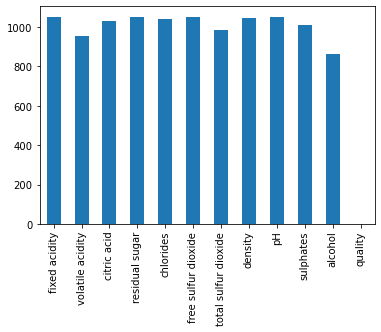

In [6]:
pd.Series(vars).plot(kind="bar")

<AxesSubplot:xlabel='quality', ylabel='prediction'>

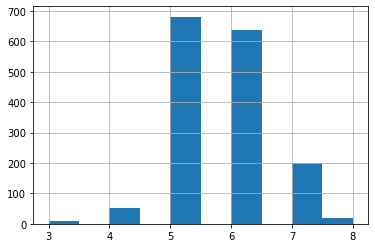

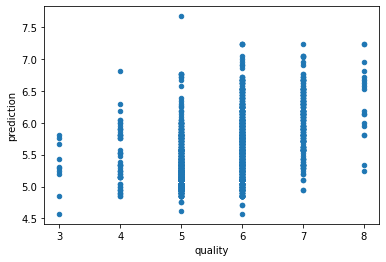

In [7]:
red_wines["prediction"] = [m.prediction[i]() for i in m.I]
red_wines["quality"].hist(label="data")

red_wines.plot(x="quality", y="prediction", kind="scatter")

## Multivariable Regression

799.1757322626268
alcohol  0.34242497
volatile acidity  -0.98061746
citric acid  -0.28927641
sulphates  0.90609119
total sulfur dioxide  -0.0021873578
density  -18.500829
fixed acidity  0.063818378


<AxesSubplot:xlabel='quality', ylabel='prediction'>

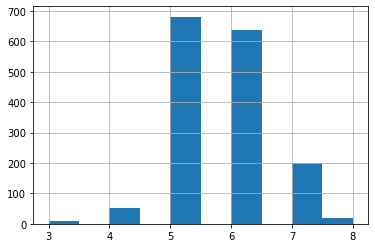

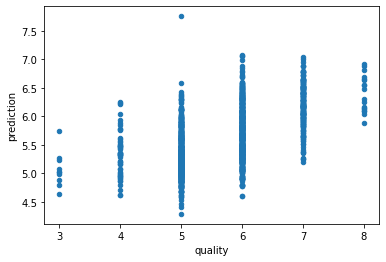

In [212]:
import pyomo.environ as pyo

def l1_fit_version2(df, y_col, x_cols):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(red_wines))
    m.J = pyo.Set(initialize=x_cols)

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I, m.J)
    def X(m, i, j):
        return df.loc[i-1, j]

    # regression
    m.a = pyo.Var(m.J)
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return sum(m.a[j] * m.X[i, j] for j in m.J) + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m.y[i]

    @m.Objective(sense=pyo.minimize)
    def sum_of_absolute_values(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = l1_fit_version2(red_wines, "quality", 
                    ["alcohol", "volatile acidity", "citric acid", "sulphates", \
                     "total sulfur dioxide", "density", "fixed acidity"])
print(m.sum_of_absolute_values())

for j in m.J:
    print(f"{j}  {m.a[j]()}")

red_wines["prediction"] = [m.prediction[i]() for i in m.I]
red_wines["quality"].hist(label="data")

red_wines.plot(x="quality", y="prediction", kind="scatter")


In [67]:
import pyomo.environ as pyo

l1 = pyo.ConcreteModel("L1 Regression Model")

l1.I = pyo.RangeSet(len(wine_quality))
l1.J = pyo.Set(initialize=["alcohol"])

@l1.Param(l1.I)
def y(l1, i):
    return wine_quality.loc[i-1, "quality"]

@l1.Param(l1.I, l1.J)
def X(l1, i, j):
    return wine_quality.loc[i-1, j]

l1.m = pyo.Var()
l1.b = pyo.Var()

l1.e_pos = pyo.Var(l1.I, domain=pyo.NonNegativeReals)
l1.e_neg = pyo.Var(l1.I, domain=pyo.NonNegativeReals)

@l1.Constraint(l1.I)
def regression(l1, i):
    return l1.e_pos[i] - l1.e_neg[i] == l1.y[i] - l1.X[i]*l1.m - l1.b

@l1.Objective()
def sum_of_absolute_values(l1):
    return sum(l1.e_pos[i] + l1.e_neg[i] for i in l1.I)

pyo.SolverFactory('cbc').solve(l1)

print(l1.m(), l1.b())
wine_quality["prediction"] = l1.m()*wine_quality["alcohol"] + l1.b()
wine_quality["prediction error"] = wine_quality["prediction"] - wine_quality["quality"]

#ax = wine_quality.plot(x="alcohol", y=["quality"], kind="scatter")
#wine_quality.plot(x="alcohol", y=["prediction"], ax=ax)

ax = wine_quality["quality"].hist()
wine_quality["prediction"].hist(ax=ax)

ERROR: Rule failed when generating expression for Constraint regression with
    index 1: KeyError: "Index '1' is not valid for indexed component 'X'"
ERROR: Constructing component 'regression' from data=None failed: KeyError:
    "Index '1' is not valid for indexed component 'X'"


KeyError: "Index '1' is not valid for indexed component 'X'"